# Training BTC Price Prediction Model
### Import Libraries and Settings

In [88]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from datetime import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [89]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load Data

In [90]:

df_btc=pd.read_csv("../data/btcusd.csv")
df_eth=pd.read_csv("../data/ethusd.csv")

In [91]:
df_btc.head()

,time,open,close,high,low,volume
0,1660209900000,24459.000000,24457.265793,24462.000000,24457.265793,2.000173
1,1660209960000,24461.093071,24460.000000,24462.000000,24459.870506,0.447423
2,1660210020000,24460.000000,24465.000000,24465.000000,24460.000000,0.091800
3,1660210080000,24464.000000,24473.794311,24473.794311,24464.000000,0.630697
4,1660210140000,24473.794311,24465.000000,24473.794311,24462.000000,0.484777


In [92]:
df_btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87537 entries, 0 to 87536
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    87537 non-null  int64  
 1   open    87537 non-null  float64
 2   close   87537 non-null  float64
 3   high    87537 non-null  float64
 4   low     87537 non-null  float64
 5   volume  87537 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 4.0 MB


In [93]:
df_eth.head()

,time,open,close,high,low,volume
0,1660209900000,1883.1,1883.800000,1884.2,1883.100000,12.352350
1,1660209960000,1884.6,1884.371626,1884.6,1884.371626,0.004962
2,1660210020000,1884.0,1884.400000,1884.4,1883.500000,1.802949
3,1660210080000,1884.5,1885.300000,1885.3,1884.500000,0.055366
4,1660210140000,1885.3,1884.584915,1885.3,1884.200000,0.262853


In [94]:
df_eth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87511 entries, 0 to 87510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    87511 non-null  int64  
 1   open    87511 non-null  float64
 2   close   87511 non-null  float64
 3   high    87511 non-null  float64
 4   low     87511 non-null  float64
 5   volume  87511 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 4.0 MB


In [95]:
# convert unicode time to human readable time
df_btc['time'] = df_btc['time'].apply(lambda d: datetime.datetime.fromtimestamp(int(d)/1000).strftime('%Y-%m-%d %H:%M:%S'))
df_btc = df_btc.set_index('time')
df_btc.index.name = None
df_btc = df_btc.drop(df_btc.columns[[0, 2, 3, 4]], axis = 1)

# only take 5 mins intervals
df_btc = df_btc.iloc[::5, :]
df_btc.head()

,close
2022-08-11 05:25:00,24457.265793
2022-08-11 05:30:00,24473.794311
2022-08-11 05:35:00,24503.000000
2022-08-11 05:40:00,24502.000000
2022-08-11 05:45:00,24495.000000


In [96]:
# convert unicode time to human readable time
df_eth['time'] = df_eth['time'].apply(lambda d: datetime.datetime.fromtimestamp(int(d)/1000).strftime('%Y-%m-%d %H:%M:%S'))
df_eth = df_eth.set_index('time')
df_eth.index.name = None
df_eth = df_eth.drop(df_eth.columns[[0, 2, 3, 4]], axis = 1)

# only take 5 mins intervals
df_eth = df_eth.iloc[::5, :]
df_eth.head()

,close
2022-08-11 05:25:00,1883.800000
2022-08-11 05:30:00,1885.300000
2022-08-11 05:35:00,1886.300000
2022-08-11 05:40:00,1889.124257
2022-08-11 05:45:00,1889.081927


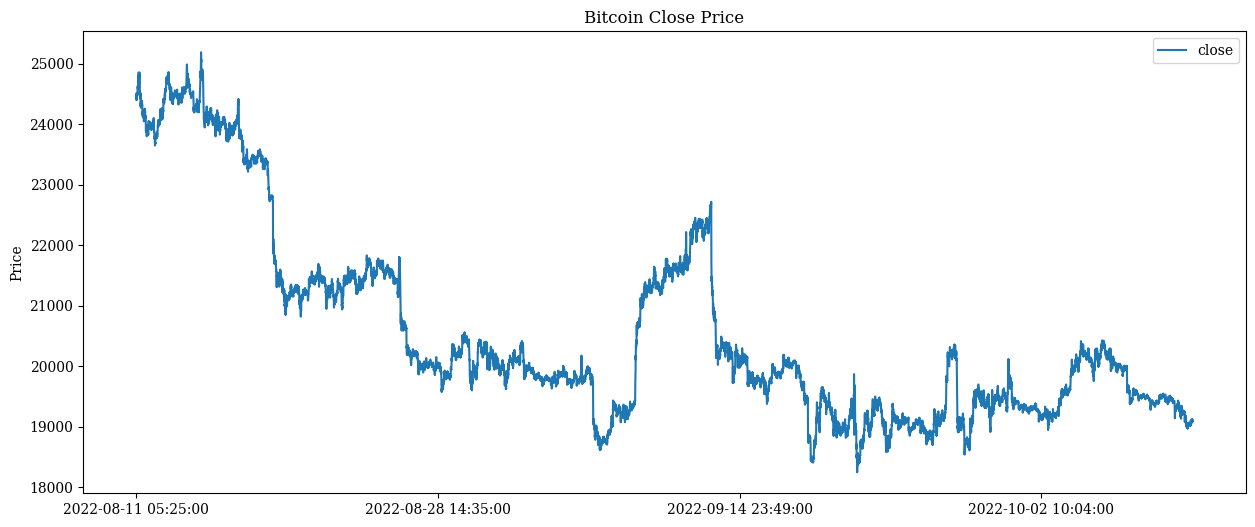

In [97]:
df_btc[['close']].plot(figsize = (15, 6))
plt.ylabel("Price")
plt.title("Bitcoin Close Price")
plt.locator_params(axis='x', nbins=8)
plt.show()

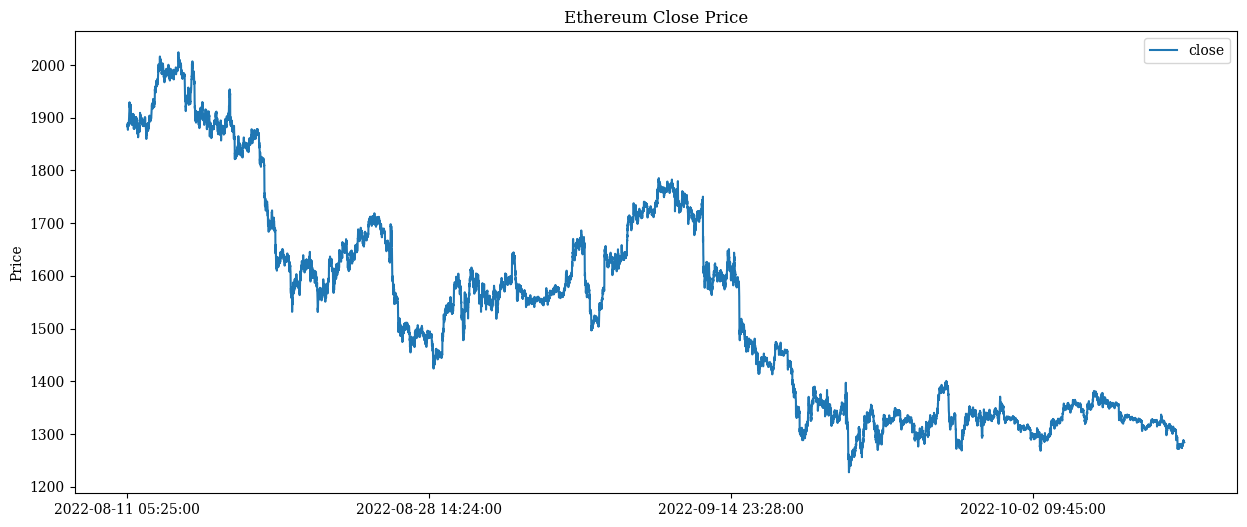

In [98]:
df_eth[['close']].plot(figsize = (15, 6))
plt.ylabel("Price")
plt.title("Ethereum Close Price")
plt.locator_params(axis='x', nbins=8)
plt.show()

### Clean & Transform Data

In [99]:
df_btc = df_btc.fillna(method='ffill')
scaler = MinMaxScaler(feature_range = (-1, 1))
df_btc['close'] = scaler.fit_transform(df_btc['close'].values.reshape(-1,1))

In [100]:
df_eth = df_eth.fillna(method='ffill')
scaler = MinMaxScaler(feature_range = (-1, 1))
df_eth['close'] = scaler.fit_transform(df_eth['close'].values.reshape(-1,1))

In [101]:
def load_data(crypto, look_back):
    data_raw = crypto.values
    data = []
    
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [102]:
look_back = 30
btc_x_train, btc_y_train, btc_x_test, btc_y_test = load_data(df_btc, look_back)
print('btc_x_train.shape = ',btc_x_train.shape)
print('btc_y_train.shape = ', btc_y_train.shape)
print('btc_x_test.shape = ', btc_x_test.shape)
print('btc_y_test.shape = ', btc_y_test.shape)

btc_x_train.shape =  (13982, 29, 1)
btc_y_train.shape =  (13982, 1)
btc_x_test.shape =  (3496, 29, 1)
btc_y_test.shape =  (3496, 1)


In [103]:
eth_x_train, eth_y_train, eth_x_test, eth_y_test = load_data(df_eth, look_back)
print('eth_x_train.shape = ', eth_x_train.shape)
print('eth_y_train.shape = ', eth_y_train.shape)
print('eth_x_test.shape = ', eth_x_test.shape)
print('eth_y_test.shape = ', eth_y_test.shape)

eth_x_train.shape =  (13978, 29, 1)
eth_y_train.shape =  (13978, 1)
eth_x_test.shape =  (3495, 29, 1)
eth_y_test.shape =  (3495, 1)


In [104]:
btc_x_train = torch.from_numpy(btc_x_train).type(torch.Tensor)
btc_x_test = torch.from_numpy(btc_x_test).type(torch.Tensor)
btc_y_train = torch.from_numpy(btc_y_train).type(torch.Tensor)
btc_y_test = torch.from_numpy(btc_y_test).type(torch.Tensor)

In [105]:
btc_y_train.size(), btc_x_train.size()

(torch.Size([13982, 1]), torch.Size([13982, 29, 1]))

In [106]:
eth_x_train = torch.from_numpy(eth_x_train).type(torch.Tensor)
eth_x_test = torch.from_numpy(eth_x_test).type(torch.Tensor)
eth_y_train = torch.from_numpy(eth_y_train).type(torch.Tensor)
eth_y_test = torch.from_numpy(eth_y_test).type(torch.Tensor)

In [107]:
eth_y_train.size(), eth_x_train.size()

(torch.Size([13978, 1]), torch.Size([13978, 29, 1]))

### Build the Model

In [108]:
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1

# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=x.device).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=x.device).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        return out

##### BTC Model

In [109]:
btc_model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
btc_model.to(device)

btc_loss_fn = torch.nn.MSELoss()
btc_loss_fn.to(device)

btc_optimiser = torch.optim.Adam(btc_model.parameters(), lr=0.01)

print(btc_model)
print(len(list(btc_model.parameters())))
for i in range(len(list(btc_model.parameters()))):
    print(list(btc_model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


##### ETH Model

In [110]:
eth_model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
eth_model.to(device)

eth_loss_fn = torch.nn.MSELoss()
eth_loss_fn.to(device)

eth_optimiser = torch.optim.Adam(eth_model.parameters(), lr=0.01)

print(eth_model)
print(len(list(eth_model.parameters())))
for i in range(len(list(eth_model.parameters()))):
    print(list(eth_model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


### Train the Model

In [111]:
num_epochs = 100
seq_dim = look_back - 1

##### Train BTC Model

In [112]:
btc_hist = np.zeros(num_epochs)

for t in range(num_epochs):
    # Forward pass
    btc_y_train_pred = btc_model(btc_x_train.to(device))

    btc_loss = btc_loss_fn(btc_y_train_pred, btc_y_train.to(device))
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", btc_loss.item())
    btc_hist[t] = btc_loss.item()

    # Zero out gradient, else they will accumulate between epochs
    btc_optimiser.zero_grad()

    # Backward pass
    btc_loss.backward()

    # Update parameters
    btc_optimiser.step()

Epoch  10 MSE:  0.02506731078028679
Epoch  20 MSE:  0.011601096950471401
Epoch  30 MSE:  0.0026832616422325373
Epoch  40 MSE:  0.002060467842966318
Epoch  50 MSE:  0.0005571512156166136
Epoch  60 MSE:  0.0004807146033272147
Epoch  70 MSE:  0.00041312380926683545
Epoch  80 MSE:  0.00034984684316441417
Epoch  90 MSE:  0.00033375583007000387


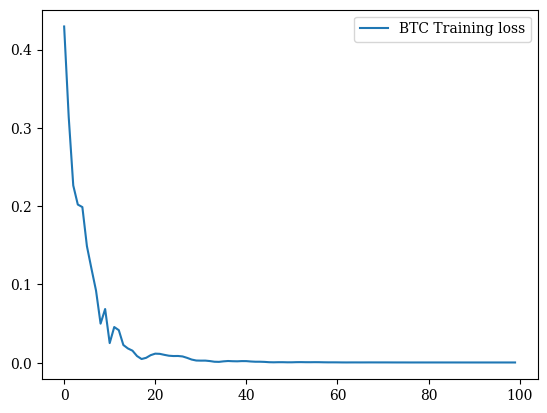

In [113]:
plt.plot(btc_hist, label="BTC Training loss")
plt.legend()
plt.show()

In [114]:
np.shape(btc_y_train_pred)

torch.Size([13982, 1])

##### Train ETH Model

In [115]:
eth_hist = np.zeros(num_epochs)

for t in range(num_epochs):
    # Forward pass
    eth_y_train_pred = eth_model(eth_x_train.to(device))

    eth_loss = eth_loss_fn(eth_y_train_pred, eth_y_train.to(device))
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", eth_loss.item())
    eth_hist[t] = eth_loss.item()

    # Zero out gradient, else they will accumulate between epochs
    eth_optimiser.zero_grad()

    # Backward pass
    eth_loss.backward()

    # Update parameters
    eth_optimiser.step()

Epoch  10 MSE:  0.059972528368234634
Epoch  20 MSE:  0.006404876243323088
Epoch  30 MSE:  0.00952548161149025
Epoch  40 MSE:  0.0047347755171358585
Epoch  50 MSE:  0.0031101354397833347
Epoch  60 MSE:  0.0019210200989618897
Epoch  70 MSE:  0.0009384662262164056
Epoch  80 MSE:  0.000480208225781098
Epoch  90 MSE:  0.0003344959404785186


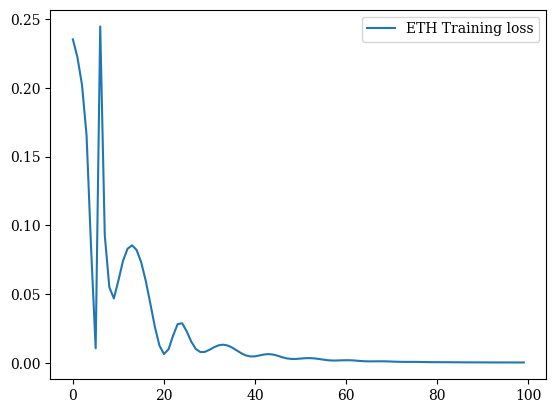

In [116]:
plt.plot(eth_hist, label="ETH Training loss")
plt.legend()
plt.show()

In [117]:
np.shape(eth_y_train_pred)

torch.Size([13978, 1])

# Make Predictions

##### BTC Price Predictions

In [118]:
btc_y_test_pred = btc_model(btc_x_test.to(device))

# invert predictions
btc_y_train_pred = scaler.inverse_transform(btc_y_train_pred.cpu().detach().numpy())
btc_y_train = scaler.inverse_transform(btc_y_train.detach().numpy())
btc_y_test_pred = scaler.inverse_transform(btc_y_test_pred.cpu().detach().numpy())
btc_y_test = scaler.inverse_transform(btc_y_test.detach().numpy())

# calculate root mean squared error
btc_trainScore = math.sqrt(mean_squared_error(btc_y_train[:,0], btc_y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (btc_trainScore))
btc_testScore = math.sqrt(mean_squared_error(btc_y_test[:,0], btc_y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (btc_testScore))

Train Score: 7.25 RMSE
Test Score: 5.36 RMSE


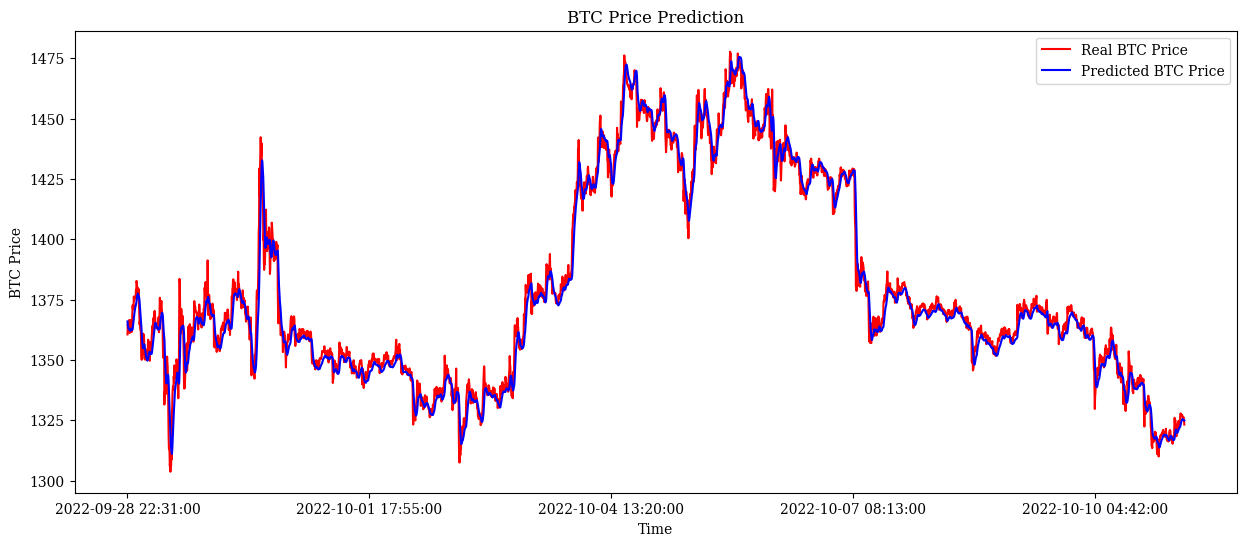

In [119]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))

axes.plot(df_btc[len(df_btc)-len(btc_y_test):].index, btc_y_test, color = 'red', label = 'Real BTC Price')
axes.plot(df_btc[len(df_btc)-len(btc_y_test):].index, btc_y_test_pred, color = 'blue', label = 'Predicted BTC Price')
axes.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.title('BTC Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend()
plt.savefig('btc_pred.png')
plt.show()

##### ETH Price Predictions

In [120]:
eth_y_test_pred = eth_model(eth_x_test.to(device))

# invert predictions
eth_y_train_pred = scaler.inverse_transform(eth_y_train_pred.cpu().detach().numpy())
eth_y_train = scaler.inverse_transform(eth_y_train.detach().numpy())
eth_y_test_pred = scaler.inverse_transform(eth_y_test_pred.cpu().detach().numpy())
eth_y_test = scaler.inverse_transform(eth_y_test.detach().numpy())

# calculate root mean squared error
eth_trainScore = math.sqrt(mean_squared_error(eth_y_train[:,0], eth_y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (eth_trainScore))
eth_testScore = math.sqrt(mean_squared_error(eth_y_test[:,0], eth_y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (eth_testScore))

Train Score: 6.48 RMSE
Test Score: 4.23 RMSE


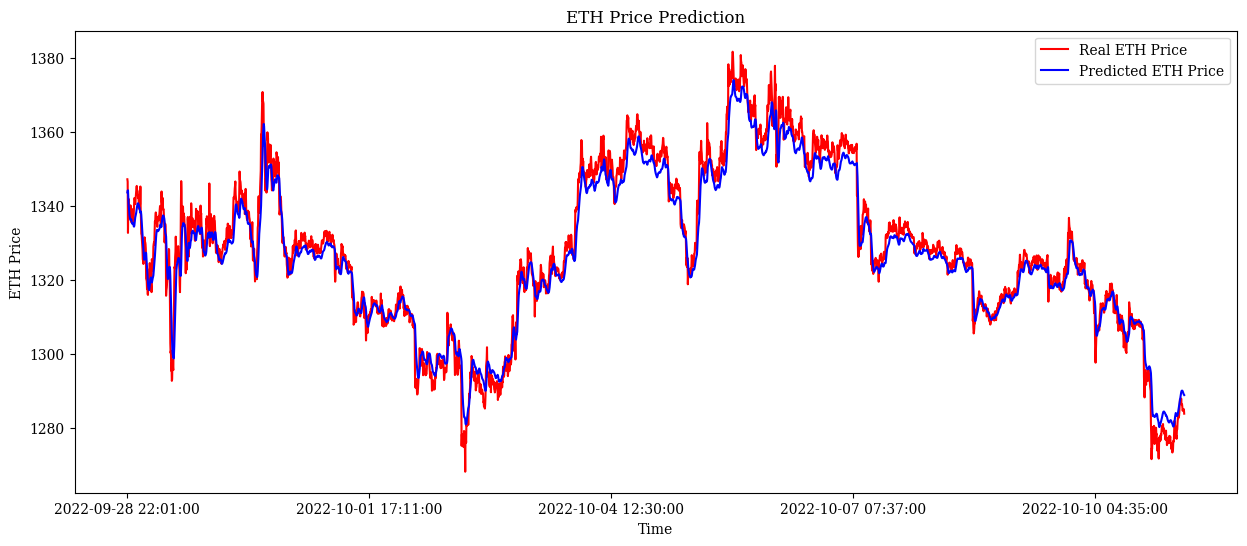

In [121]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))

axes.plot(df_eth[len(df_eth)-len(eth_y_test):].index, eth_y_test, color = 'red', label = 'Real ETH Price')
axes.plot(df_eth[len(df_eth)-len(eth_y_test):].index, eth_y_test_pred, color = 'blue', label = 'Predicted ETH Price')
axes.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.title('ETH Price Prediction')
plt.xlabel('Time')
plt.ylabel('ETH Price')
plt.legend()
plt.savefig('eth_pred.png')
plt.show()